In [39]:
CELOSS =  "Cross Entropy"
POLYLOSS = "Poly-tailed Loss"

In [2]:
import wandb
import os
import pickle
import shutil
from pathlib import Path
from typing import List, Union


def get_runs(user="", project="", query={}, **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    return runs
    #dataframes = [run.history(**kwargs) for run in runs]
    #return list(zip(runs, dataframes))

In [3]:
# CelebA
queries = {}
## ERM
queries["erm"] = ("kealexanderwang",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-10-01_celeba_2", "2021-10-04_cifar"]}},
              {"tags": "erm"},
              {"tags": {"$ne": "ignore"}},
             ]
})

## RW
queries["rw"] = ("kealexanderwang",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-10-01_celeba_2", "2021-10-04_cifar"]}},
              {"tags": "reweighted"},
              {"tags": {"$ne": "early-stopped"}},
              {"tags": {"$ne": "ignore"}},
             ]
})

## RW + Early stop
queries["rwes"] = ("kealexanderwang",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-10-01_celeba_2", "2021-10-04_cifar"]}},
              {"tags": "early-stopped"},
              {"tags": "reweighted"},
              {"tags": {"$ne": "ignore"}},
             ]
})


# TODO: Runs below

## RW2 exponentiated
queries["rwexp"] = ("kealexanderwang",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-10-03_celeba_exponent", "2021-10-03_cifar_exponent"]}},
              {"tags": "reweighted"},
              {"tags": {"$ne": "early-stopped"}},
              {"tags": {"$ne": "ignore"}},
             ]
})

## RW-2x
# queries["rw2x"] = ("nschat",
#     {"$and": [{"state": "finished"},
#               {"group": {"$in": ["2021-09-21_subsampled-celeba", "2021-09-22_cifar"]}},
#               {"tags": "reweighted"},
#               {"tags": {"$ne": "early-stopped"}},
#              ]
# })

## RW-2x + Early stop
# queries["rw2xes"] = ("nschat",
#     {"$and": [{"state": "finished"},
#               {"group": {"$in": ["2021-09-21_subsampled-celeba", "2021-09-22_cifar"]}},
#               {"tags": "early-stopped"},
#               {"tags": "reweighted"},
#              ]
# })
queries["rwexpes"] = ("kealexanderwang",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-10-03_celeba_exponent", "2021-10-03_cifar_exponent"]}},
              {"tags": "reweighted"},
              {"tags": "early-stopped"},
              {"tags": {"$ne": "ignore"}},
             ]
})


## RW32x
# queries["rw32x"] = ("nschat",
#     {"$and": [{"state": "finished"},
#               {"group": {"$in": ["2021-09-22_cifar_scaled_up"]}},
#               {"tags": "reweighted"},
#               {"tags": {"$ne": "early-stopped"}},
#              ]
# })

# ## RW32x + Early stop
# queries["rw32xes"] = ("nschat",
#     {"$and": [{"state": "finished"},
#               {"group": {"$in": ["2021-09-22_cifar_scaled_up"]}},
#               {"tags": "early-stopped"},
#               {"tags": "reweighted"},
#              ]
# })

In [4]:
def parse_run(run):
    config = run.config
    df = run.history(keys=["test/test_reweighted_acc"])
    
    acc = df["test/test_reweighted_acc"].dropna().iloc[0] # there should only be one logged
    assert acc > 0.
    stats = {
        "name": run.name,
        "loss": config["loss_fn/_target_"],
        "dataset": config["datamodule/group_datamodule_cls_name"],
        "seed": config["seed"],
        "acc": acc,
    }
    return stats

In [5]:
stats_list = []
for query_name, user__query in queries.items():
    user, query = user__query
    project = "importance-reweighing"
    runs = get_runs(user=user, project=project, query=query)
    stats_of_runs = [parse_run(run) for run in runs]
    
    for stats in stats_of_runs:
        stats["query"] = query_name
    
    stats_list += stats_of_runs

In [6]:
import pandas as pd

df = pd.DataFrame(stats_list)

In [7]:
df[(df["dataset"] == "CelebADataModule") & (df["query"] == "rwes")]

,name,loss,dataset,seed,acc,query
100,distinctive-galaxy-1327,src.loss_fns.PolynomialLoss,CelebADataModule,8,0.895833,rwes
101,dulcet-salad-1286,src.loss_fns.PolynomialLoss,CelebADataModule,9,0.847222,rwes
102,jolly-glade-1285,torch.nn.CrossEntropyLoss,CelebADataModule,9,0.844444,rwes
103,apricot-cloud-1284,torch.nn.CrossEntropyLoss,CelebADataModule,8,0.818055,rwes
104,lucky-resonance-1275,src.loss_fns.PolynomialLoss,CelebADataModule,7,0.840278,rwes
105,deep-yogurt-1273,torch.nn.CrossEntropyLoss,CelebADataModule,7,0.844444,rwes
106,atomic-thunder-1271,src.loss_fns.PolynomialLoss,CelebADataModule,6,0.825000,rwes
107,ethereal-terrain-1267,torch.nn.CrossEntropyLoss,CelebADataModule,6,0.893055,rwes
108,revived-plant-1260,torch.nn.CrossEntropyLoss,CelebADataModule,5,0.825000,rwes
109,trim-wildflower-1259,src.loss_fns.PolynomialLoss,CelebADataModule,5,0.811111,rwes


In [8]:
df.head(2)

,name,loss,dataset,seed,acc,query
0,worldly-dust-1701,torch.nn.CrossEntropyLoss,ImbalancedCIFAR10DataModule,9,0.6380,erm
1,wandering-smoke-1700,torch.nn.CrossEntropyLoss,ImbalancedCIFAR10DataModule,8,0.6275,erm


In [9]:
def remap(old, new, arg):
    return new if arg == old else arg

In [10]:
df["loss"] = df["loss"].apply(lambda a: remap("torch.nn.CrossEntropyLoss", CELOSS, a))
df["loss"] = df["loss"].apply(lambda a: remap("src.loss_fns.PolynomialLoss", POLYLOSS, a))

In [11]:
df["query"] = df["query"].apply(lambda a: remap("erm", "No IW", a))
df["query"] = df["query"].apply(lambda a: remap("rw", "IW", a))
df["query"] = df["query"].apply(lambda a: remap("rwexp", "IW-Exp", a))

df["query"] = df["query"].apply(lambda a: remap("rwes", "IW-ES", a))
df["query"] = df["query"].apply(lambda a: remap("rwexpes", "IW-Exp-ES", a))

In [12]:
df.to_csv("results.csv", index=False)

# Begin plots

In [40]:
import pandas as pd
df = pd.read_csv("results.csv")

In [41]:
df = df.sort_values("loss", ascending=False)

In [42]:
from collections import defaultdict
p_values = {"ImbalancedCIFAR10DataModule": defaultdict(float),
            "CelebADataModule": defaultdict(float),
}

In [43]:
from hypothetical.hypothesis import tTest

dataset_name = "ImbalancedCIFAR10DataModule"
df_ = df[df["dataset"] == dataset_name]
for query in df_["query"].unique():
    ce_accs = df_.loc[(df_["loss"] == CELOSS) & (df_["query"] == query), ["seed", "acc"]]
    poly_accs = df_.loc[(df_["loss"] == POLYLOSS) & (df_["query"] == query), ["seed", "acc"]]
    
    ce_accs = ce_accs.set_index("seed")
    poly_accs = poly_accs.set_index("seed")
    
#     if query == "IW":
#         ce_accs = ce_accs.drop(index=4)  # seed 4 failed for poly loss, so we also drop cross entropy results
    
    acc_pairs = pd.concat([ce_accs.rename(columns={"acc": "ce_acc"}), poly_accs.rename(columns={"acc": "poly_acc"})], axis=1)
    
    ttest = tTest(y1=acc_pairs["poly_acc"],
              y2=acc_pairs["ce_acc"],
              var_equal=False,
              paired=True,
              alternative="greater",
              alpha=0.05
    )
    p_value = ttest.test_summary['p-value']
    print(f"{query}: {p_value:.5f}")
    p_values[dataset_name][query] = p_value

IW-ES: 0.02164
IW-Exp: 0.00000
IW-Exp-ES: 0.00138
IW: 0.00000
No IW: 0.99991


In [44]:
from hypothetical.hypothesis import tTest

dataset_name = "CelebADataModule"
df_ = df[df["dataset"] == dataset_name]
for query in df_["query"].unique():    
    ce_accs = df_.loc[(df_["loss"] == CELOSS) & (df_["query"] == query), ["seed", "acc"]]
    poly_accs = df_.loc[(df_["loss"] == POLYLOSS) & (df_["query"] == query), ["seed", "acc"]]
    
    ce_accs = ce_accs.set_index("seed")
    poly_accs = poly_accs.set_index("seed")
    
    acc_pairs = pd.concat([ce_accs.rename(columns={"acc": "ce_acc"}), poly_accs.rename(columns={"acc": "poly_acc"})], axis=1)
    
    ttest = tTest(y1=acc_pairs["poly_acc"],
              y2=acc_pairs["ce_acc"],
              var_equal=False,
              paired=True,
              alternative="greater",
              alpha=0.05
    )
    p_value = ttest.test_summary['p-value']
    print(f"{query}: {p_value:.6f}")
    p_values[dataset_name][query] = p_value

IW-ES: 0.761778
IW: 0.014324
IW-Exp: 0.000003
IW-Exp-ES: 0.202053
No IW: 0.998733


In [45]:
import numpy as np
df_ = df.copy()
df_ = df_.drop(columns=["name"])

df_.loc[:, "ES"] = df_.loc[:, "query"].str.contains("ES")
df_.loc[:, "interp"] = ~df_.loc[:, "ES"]

df_ = df_.melt(id_vars=["dataset", "loss", "acc", "seed", "query"],
               var_name="group",
               value_name="tmp")
df_ = df_.drop(columns="tmp")
df_ = df_.pivot_table(index=["dataset", "group", "query", "seed"], columns="loss", values="acc")

def hypothesis_test(group):
    ttest = tTest(y1=group[POLYLOSS],
                  y2=group[CELOSS],
                  var_equal=False,
                  paired=True,
                  alternative="greater",
                  alpha=0.05
    )
    p_value = ttest.test_summary['p-value']
    return p_value

def stderr(x):
    return x.std() / len(x) ** 0.5

means = df_.groupby(level=[0,1,2]).agg(np.mean).round(3)
stderrs = df_.groupby(level=[0,1,2]).agg(stderr).round(3)
p_values_df = df_.groupby(level=[0,1,2]).apply(hypothesis_test).round(3)
p_values_df = p_values_df.to_frame(name="p-value")

In [46]:
table = means.merge(stderrs, left_index=True, right_index=True, suffixes=[" mean accuracy", " standard error"])
table = table.merge(p_values_df, left_index=True, right_index=True, suffixes=["", ""])
table = table.reindex(columns=["Cross Entropy mean accuracy", "Cross Entropy standard error", "Poly-tailed Loss mean accuracy", "Poly-tailed Loss standard error", "p-value"])

In [47]:
new_columns = pd.MultiIndex.from_tuples([("Cross Entropy", "mean"), ("Cross Entropy", "standard error"), ("Poly-tailed Loss", "mean"), ("Poly-tailed Loss", "standard error"), ("", "p-value")])

In [48]:
table.columns = new_columns

In [49]:
table

Cross Entropy                 \
                                                      mean standard error   
dataset                     group  query                                    
CelebADataModule            ES     IW                0.793          0.004   
                                   IW-ES             0.849          0.007   
                                   IW-Exp            0.787          0.004   
                                   IW-Exp-ES         0.851          0.007   
                                   No IW             0.796          0.004   
                            interp IW                0.793          0.004   
                                   IW-ES             0.849          0.007   
                                   IW-Exp            0.787          0.004   
                                   IW-Exp-ES         0.851          0.007   
                                   No IW             0.796          0.004   
ImbalancedCIFAR10DataModule ES     IW                0.578          0.004   
                                   IW-ES             0.625          0.007   
                                   IW-Exp            0.574          0.006   
                                   IW-Exp-ES         0.612          0.008   
                                   No IW             0.605          0.008   
                            interp IW                0.578          0.004   
                                   IW-ES             0.625          0.007   
                                   IW-Exp            0.574          0.006   
                                   IW-Exp-ES         0.612          0.008   
                                   No IW             0.605          0.008   

                                             Poly-tailed Loss                 \
                                                         mean standard error   
dataset                     group  query                                       
CelebADataModule            ES     IW                   0.807          0.006   
                                   IW-ES                0.840          0.009   
                                   IW-Exp               0.827          0.004   
                                   IW-Exp-ES            0.859          0.008   
                                   No IW                0.785          0.004   
                            interp IW                   0.807          0.006   
                                   IW-ES                0.840          0.009   
                                   IW-Exp               0.827          0.004   
                                   IW-Exp-ES            0.859          0.008   
                                   No IW                0.785          0.004   
ImbalancedCIFAR10DataModule ES     IW                   0.604          0.003   
                                   IW-ES                0.634          0.005   
                                   IW-Exp               0.630          0.006   
                                   IW-Exp-ES            0.635          0.006   
                                   No IW                0.564          0.004   
                            interp IW                   0.604          0.003   
                                   IW-ES                0.634          0.005   
                                   IW-Exp               0.630          0.006   
                                   IW-Exp-ES            0.635          0.006   
                                   No IW                0.564          0.004   

                                                      
                                             p-value  
dataset                     group  query              
CelebADataModule            ES     IW          0.014  
                                   IW-ES       0.762  
                                   IW-Exp      0.000  
                                   IW-Exp-ES   0.202  
                                   No IW       

In [50]:
print(table.to_latex())

\begin{tabular}{lllrrrrr}
\toprule
                            &        &       & \multicolumn{2}{l}{Cross Entropy} & \multicolumn{3}{l}{Poly-tailed Loss} \\
                            &        &       &          mean & standard error &             mean & standard error & p-value \\
dataset & group & query &               &                &                  &                &         \\
\midrule
CelebADataModule & ES & IW &         0.793 &          0.004 &            0.807 &          0.006 &   0.014 \\
                            &        & IW-ES &         0.849 &          0.007 &            0.840 &          0.009 &   0.762 \\
                            &        & IW-Exp &         0.787 &          0.004 &            0.827 &          0.004 &   0.000 \\
                            &        & IW-Exp-ES &         0.851 &          0.007 &            0.859 &          0.008 &   0.202 \\
                            &        & No IW &         0.796 &          0.004 &            0.785 &       

In [55]:
df_.index

MultiIndex([(           'CelebADataModule',     'ES',    'IW', 0),
            (           'CelebADataModule',     'ES',    'IW', 1),
            (           'CelebADataModule',     'ES',    'IW', 2),
            (           'CelebADataModule',     'ES',    'IW', 3),
            (           'CelebADataModule',     'ES',    'IW', 4),
            (           'CelebADataModule',     'ES',    'IW', 5),
            (           'CelebADataModule',     'ES',    'IW', 6),
            (           'CelebADataModule',     'ES',    'IW', 7),
            (           'CelebADataModule',     'ES',    'IW', 8),
            (           'CelebADataModule',     'ES',    'IW', 9),
            ...
            ('ImbalancedCIFAR10DataModule', 'interp', 'No IW', 0),
            ('ImbalancedCIFAR10DataModule', 'interp', 'No IW', 1),
            ('ImbalancedCIFAR10DataModule', 'interp', 'No IW', 2),
            ('ImbalancedCIFAR10DataModule', 'interp', 'No IW', 3),
            ('ImbalancedCIFAR10DataModule', 'i

In [69]:
y1 = df_.loc[("ImbalancedCIFAR10DataModule", "interp", "No IW"), "Cross Entropy"]
y2 = df_.loc[("ImbalancedCIFAR10DataModule", "interp", "IW-Exp"), "Poly-tailed Loss"]

In [70]:
y1.mean()

0.6045999646186828

In [71]:
y2.mean()

0.6302499771118164

In [73]:
cifar_p_value = hypothesis_test(pd.concat([y1, y2], axis=1))

In [24]:
def get_corners(rectangle):
    b = rectangle
    w,h = b.get_width(), b.get_height()
    # lower left vertex
    x0, y0 = b.xy
    # lower right vertex
    x1, y1 = x0 + w, y0
    # top left vertex
    x2, y2 = x0, y0 + h
    # top right vertex
    x3, y3 = x0 + w, y0 + h
    return (x0,y0), (x1,y1), (x2,y2), (x3,y3)

In [25]:
def outline_bracket(left_bar, right_bar, spacing, height):
    l0, l1, l2, l3 = get_corners(left_bar)
    r0, r1, r2, r3 = get_corners(right_bar)
    
    # lower left
    b0 = ((l0[0] + l1[0]) / 2, max(l2[1], r2[1]) + spacing)
    # upper left
    b1 = (b0[0], max(l2[1] + spacing, r2[1] + spacing) + height)
    # upper right
    b2 = ((r0[0] + r1[0]) / 2, b1[1])
    # lower right
    b3 = (b2[0], b0[1])
    return b0, b1, b2, b3

## Interpolation results

In [26]:
df_interp = df[df["query"].isin(["No IW", "IW", "IW-Exp"])]

In [27]:
df_interp

,name,loss,dataset,seed,acc,query
155,smart-violet-1539,Poly-tailed Loss,ImbalancedCIFAR10DataModule,2,0.647000,IW-Exp
156,easy-shadow-1534,Poly-tailed Loss,ImbalancedCIFAR10DataModule,1,0.631500,IW-Exp
159,polar-monkey-1524,Poly-tailed Loss,ImbalancedCIFAR10DataModule,0,0.628500,IW-Exp
78,youthful-universe-1231,Poly-tailed Loss,CelebADataModule,0,0.812500,IW
76,chocolate-frost-1235,Poly-tailed Loss,CelebADataModule,1,0.802778,IW
...,...,...,...,...,...,...
79,zesty-flower-1230,Cross Entropy,CelebADataModule,0,0.779167,IW
77,jolly-armadillo-1234,Cross Entropy,CelebADataModule,1,0.784722,IW
75,spring-pine-1240,Cross Entropy,CelebADataModule,2,0.779167,IW
73,generous-frog-1247,Cross Entropy,CelebADataModule,3,0.780555,IW


Text(0.5, 1.02, 'Trained to Interpolation')

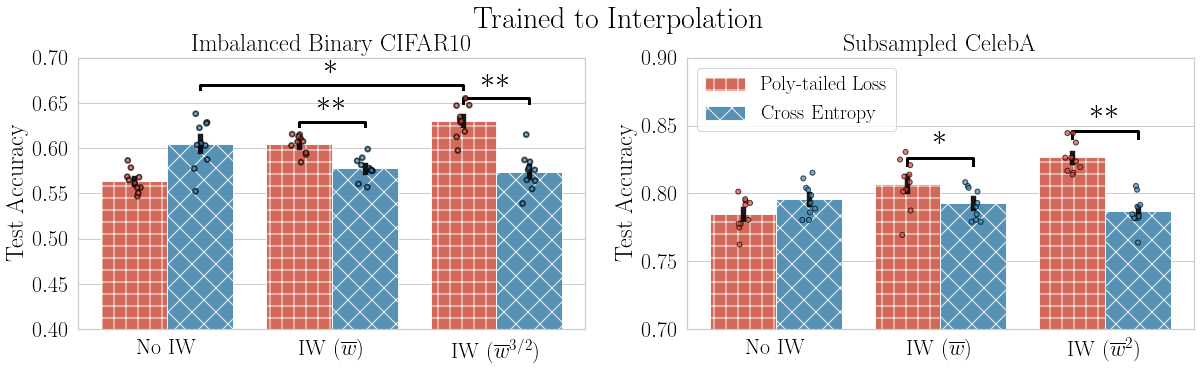

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

plt.rc('text', usetex=True)
plt.rc('font', family='times')
palette = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
sns.set_palette(palette)

fig, axes = plt.subplots(figsize=(20, 5), ncols=2)
ax = axes[0]
dataset_name = "ImbalancedCIFAR10DataModule"
bar = sns.barplot(data=df_interp[df_interp["dataset"] == dataset_name], x="query", y="acc", hue="loss", ax=ax, alpha=0.9, saturation=0.75, order=["No IW", "IW", "IW-Exp"], ci=68, errcolor=(0, 0, 0, 0.9))
sns.stripplot(data=df_interp[df_interp["dataset"] == dataset_name], x="query", y="acc", hue="loss", ax=ax, alpha=0.7, order=["No IW", "IW", "IW-Exp"], dodge=True, edgecolor="black", linewidth=1.7)
ax.set(ylim=[0.4, 0.7])
ax.legend().remove()
ax.set(title=r"Imbalanced Binary CIFAR10")
ax.set(ylabel=r"Test Accuracy")
ax.set(xlabel=None)
ax.set(xlabel=None)

hatches = ["+","+","+", "x", "x", "x"]
for i, b in enumerate(bar.patches):
    b.set_hatch(hatches[i])
    b.set_edgecolor((1, 1, 1, 1.))

queries = [label.get_text() for label in ax.get_xticklabels()]

for i in range(len(queries)):
    query = queries[i]
    p_value = p_values[dataset_name][query]
    if p_value < 0.05:
        star = r"$**$" if p_value < 0.005 else r"$*$"

        left_bar = bar.patches[i]
        right_bar = bar.patches[i + len(queries)]
        bracket = outline_bracket(left_bar, right_bar, spacing=0.02, height=0.005)
        b_xs, b_ys = list(zip(*bracket))
        ax.plot(b_xs, b_ys, c="k")
        ax.text((b_xs[1] + b_xs[2]) / 2, b_ys[1] + 0.005, star, ha="center", va="bottom", color="k", fontsize=30)
        
if cifar_p_value < 0.05:
    star = r"$**$" if cifar_p_value < 0.005 else r"$*$"

    left_bar = bar.patches[3]
    right_bar = bar.patches[2]
    bracket = outline_bracket(left_bar, right_bar, spacing=0.035, height=0.005)
    b_xs, b_ys = list(zip(*bracket))
    ax.plot(b_xs, b_ys, c="k")
    ax.text((b_xs[1] + b_xs[2]) / 2, b_ys[1] + 0.005, star, ha="center", va="bottom", color="k", fontsize=30)    

ax.set(xticklabels=["No IW", "IW ($\overline w$)", r"IW ($\overline w^{3/2})$"])  # Put at the end because p_values dict is named using old keys
ax.set_axisbelow(True)

dataset_name = "CelebADataModule"
ax = axes[1]
bar = sns.barplot(data=df_interp[df_interp["dataset"] == dataset_name], x="query", y="acc", hue="loss", ax=ax, alpha=0.9, saturation=0.75, order=["No IW", "IW", "IW-Exp"], ci=68, errcolor=(0, 0, 0, 0.9))
sns.stripplot(data=df_interp[df_interp["dataset"] == dataset_name], x="query", y="acc", hue="loss", ax=ax, alpha=0.7, order=["No IW", "IW", "IW-Exp"], dodge=True, edgecolor="black", linewidth=1)
ax.set(ylim=[0.7, 0.9])
ax.set(title=r"Subsampled CelebA")
ax.set(ylabel=r"Test Accuracy")
ax.set(xlabel=None)

hatches = ["+","+","+", "x", "x", "x"]
for i, b in enumerate(bar.patches):
    b.set_hatch(hatches[i])
    b.set_edgecolor((1, 1, 1, 1.))

queries = [label.get_text() for label in ax.get_xticklabels()]

for i in range(len(queries)):
    query = queries[i]
    p_value = p_values[dataset_name][query]
    if p_value < 0.05:
        star = r"$**$" if p_value < 0.005 else r"$*$"

        left_bar = bar.patches[i]
        right_bar = bar.patches[i + len(queries)]
        bracket = outline_bracket(left_bar, right_bar, spacing=0.014, height=0.005)
        b_xs, b_ys = list(zip(*bracket))
        ax.plot(b_xs, b_ys, c="k")
        ax.text((b_xs[1] + b_xs[2]) / 2, b_ys[1] + 0.005, star, ha="center", va="bottom", color="k", fontsize=30)
ax.set(xticklabels=["No IW", r"IW ($\overline w$)", r"IW ($\overline w^{2})$"])
ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:], fontsize=20, loc="upper left")
fig.suptitle("Trained to Interpolation", fontsize=30, y=1.02)

In [79]:
fig.savefig("interpolated.pdf", bbox_inches="tight")

## Early stopped results

In [30]:
df_es = df[df["query"].isin(["IW", "IW-ES", "IW-Exp-ES"])]

Text(0.5, 1.02, 'Early-stopped')

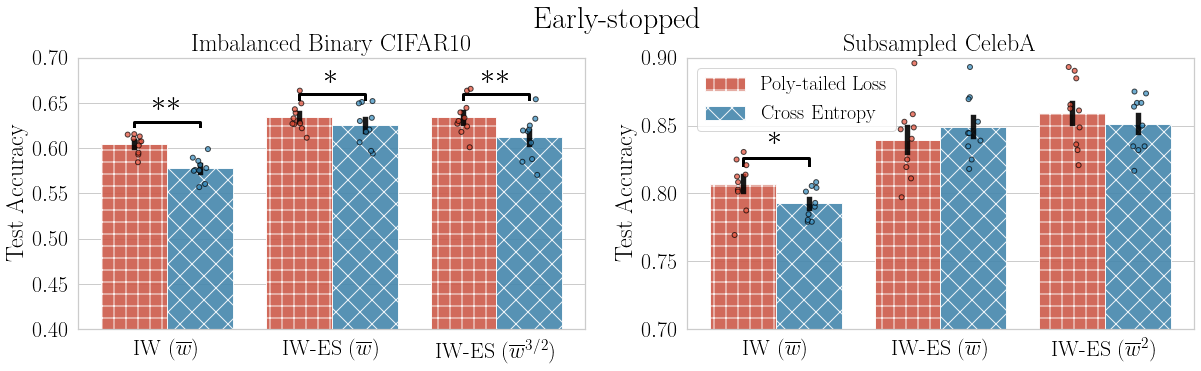

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

plt.rc('text', usetex=True)
plt.rc('font', family='times')
palette = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
sns.set_palette(palette)

fig, axes = plt.subplots(figsize=(20, 5), ncols=2)
ax = axes[0]
dataset_name = "ImbalancedCIFAR10DataModule"
bar = sns.barplot(data=df_es[df_es["dataset"] == dataset_name], x="query", y="acc", hue="loss", ax=ax, alpha=0.9, saturation=0.75, order=["IW", "IW-ES", "IW-Exp-ES"], ci=68, errcolor=(0, 0, 0, 0.9))
sns.stripplot(data=df_es[df_es["dataset"] == dataset_name], x="query", y="acc", hue="loss", ax=ax, alpha=0.7, order=["IW", "IW-ES", "IW-Exp-ES"], dodge=True, edgecolor="black", linewidth=1)
ax.set(ylim=[0.4, 0.7])
ax.legend().remove()
ax.set(title=r"Imbalanced Binary CIFAR10")
ax.set(ylabel=r"Test Accuracy")
ax.set(xlabel=None)

hatches = ["+","+","+", "x", "x", "x"]
for i, b in enumerate(bar.patches):
    b.set_hatch(hatches[i])
    b.set_edgecolor((1, 1, 1, 1.))

queries = [label.get_text() for label in ax.get_xticklabels()]

for i in range(len(queries)):
    query = queries[i]
    p_value = p_values[dataset_name][query]
    if p_value < 0.05:
        star = r"$**$" if p_value < 0.005 else r"$*$"

        left_bar = bar.patches[i]
        right_bar = bar.patches[i + len(queries)]
        bracket = outline_bracket(left_bar, right_bar, spacing=0.02, height=0.005)
        b_xs, b_ys = list(zip(*bracket))
        ax.plot(b_xs, b_ys, c="k")
        ax.text((b_xs[1] + b_xs[2]) / 2, b_ys[1] + 0.005, star, ha="center", va="bottom", color="k", fontsize=30)    
ax.set(xticklabels=[r"IW ($\overline w$)", r"IW-ES ($\overline w$)", r"IW-ES ($\overline w^{3/2}$)"])
ax.set_axisbelow(True)
        
dataset_name = "CelebADataModule"
ax = axes[1]
bar = sns.barplot(data=df_es[df_es["dataset"] == dataset_name], x="query", y="acc", hue="loss", ax=ax, alpha=0.9, saturation=0.75, order=["IW", "IW-ES", "IW-Exp-ES"], ci=68, errcolor=(0, 0, 0, 0.9))
sns.stripplot(data=df_es[df_es["dataset"] == dataset_name], x="query", y="acc", hue="loss", ax=ax, alpha=0.7, order=["IW", "IW-ES", "IW-Exp-ES"], dodge=True, edgecolor="black", linewidth=1)
ax.set(ylim=[0.7, 0.9])
ax.set(title=r"Subsampled CelebA")
ax.set(ylabel=r"Test Accuracy")
ax.set(xlabel=None)

hatches = ["+","+","+", "x", "x", "x"]
for i, b in enumerate(bar.patches):
    b.set_hatch(hatches[i])
    b.set_edgecolor((1, 1, 1, 1.))

queries = [label.get_text() for label in ax.get_xticklabels()]

for i in range(len(queries)):
    query = queries[i]
    p_value = p_values[dataset_name][query]
    if p_value < 0.05:
        star = r"$**$" if p_value < 0.005 else r"$*$"

        left_bar = bar.patches[i]
        right_bar = bar.patches[i + len(queries)]
        bracket = outline_bracket(left_bar, right_bar, spacing=0.014, height=0.005)
        b_xs, b_ys = list(zip(*bracket))
        ax.plot(b_xs, b_ys, c="k")
        ax.text((b_xs[1] + b_xs[2]) / 2, b_ys[1] + 0.005, star, ha="center", va="bottom", color="k", fontsize=30)    
ax.set(xticklabels=[r"IW ($\overline w$)", r"IW-ES ($\overline w$)", r"IW-ES ($\overline w^{2}$)"])
ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:], fontsize=20, loc="upper left")
fig.suptitle("Early-stopped", fontsize=30, y=1.02)

In [32]:
fig.savefig("early-stopped.pdf", bbox_inches="tight")